In [65]:
import os
import cv2
import math
import random

import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

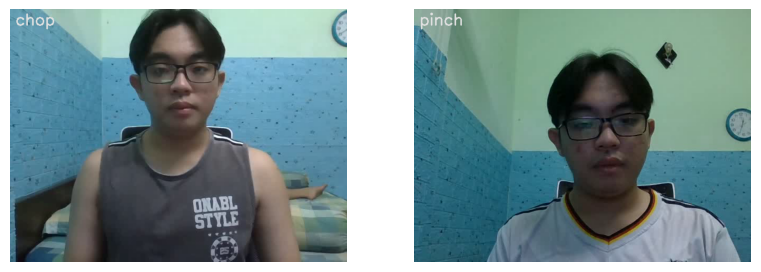

In [66]:
plt.figure(figsize = (20, 20))

allClassesName = os.listdir('data')
randomRange = random.sample(range(len(allClassesName)), 2)


for counter, randomIndex in enumerate(randomRange, 1):
  selectedClassName = allClassesName[randomIndex]

  videoFilesNameList = os.listdir(f'data/{selectedClassName}')
  selectedVideoFileName = random.choice(videoFilesNameList)

  videoReader = cv2.VideoCapture(f'data/{selectedClassName}/{selectedVideoFileName}')

  _, frame = videoReader.read()
  videoReader.release()

  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

  cv2.putText(frame, selectedClassName, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (225, 225, 225), 2)

  plt.subplot(5, 4, counter)
  plt.imshow(frame)
  plt.axis('off')


In [67]:
imageSize = (64, 64)

numberOfFrames = 30

dataDir = 'data'

classesList = ['chop', 'pinch']

In [68]:
def FrameExtraction(videoPath):

  framesList = []
  videoReader = cv2.VideoCapture(videoPath)
  framesCount = int(videoReader.get(cv2.CAP_PROP_FRAME_COUNT))
  skipFrame = max(int(framesCount/numberOfFrames), 1)

  for frameCounter in range(numberOfFrames):
    videoReader.set(cv2.CAP_PROP_POS_FRAMES, frameCounter * skipFrame)

    success, frame = videoReader.read()

    if not success:
      break

    resizedFrame = cv2.resize(frame, imageSize)

    normalizedFrame = resizedFrame/255.0

    framesList.append(normalizedFrame)

  videoReader.release()

  return framesList

In [69]:
def CreateDataset():
  data = []
  label = []
  videosPath = []

  for index, className in enumerate(classesList):
    print(f'Extracting data of the class {className}')

    fileList = os.listdir(os.path.join(dataDir, className))

    for fileName in fileList:
      videoPath = os.path.join(dataDir, className, fileName)

      frames = FrameExtraction(videoPath)

      if len(frames) == numberOfFrames:
        data.append(frames)
        label.append(index)
        videosPath.append(videoPath)

  data = np.array(data)
  label = np.array(label)
  return data, label, videosPath

In [70]:
data, label, videosPath = CreateDataset()

Extracting data of the class chop
Extracting data of the class pinch


In [71]:
label_ohe = to_categorical(label)

In [72]:
XTrain, XTest, yTrain, yTest = train_test_split(data, label_ohe, random_state=27, shuffle=True, test_size=0.01)

In [73]:
def CreateModel():
  model = Sequential()

  model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh',
                      data_format='channels_last', recurrent_dropout=0.2,
                      return_sequences=True,
                      input_shape=(numberOfFrames, 64, 64, 3)))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh',
                      data_format='channels_last', recurrent_dropout=0.2,
                      return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh',
                      data_format='channels_last', recurrent_dropout=0.2,
                      return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh',
                      data_format='channels_last', recurrent_dropout=0.2,
                      return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  # Flattening the data to feed into Dense layers
  model.add(Flatten())

  # Final Dense layer with softmax activation for classification
  model.add(Dense(len(classesList), activation='softmax'))

  model.summary()

  return model

In [74]:
model = CreateModel()

d:\Phong\Coding\Hand Tracking\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_12 (ConvLSTM2D)     │ (None, 30, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_12 (MaxPooling3D) │ (None, 30, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 30, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_13 (ConvLSTM2D)     │ (None, 30, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_13 (MaxPooling3D) │ (None, 30, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 30, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_14 (ConvLSTM2D)     │ (None, 30, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_14 (MaxPooling3D) │ (None, 30, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 30, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_15 (ConvLSTM2D)     │ (None, 30, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_15 (MaxPooling3D) │ (None, 30, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 30, 3, 3, 16)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4320)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         8,642 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,642 (162.66 KB)

 Trainable params: 41,642 (162.66 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# plot_model(model,
#            to_file='convlstm_model_structure_plot.png',
#            show_shapes=True,
#            show_layer_names=True)

In [76]:
earlyStoppingCallback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

history = model.fit(XTrain, yTrain, epochs=10, batch_size=20, shuffle=True, validation_split=0.2, callbacks=[earlyStoppingCallback])

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 517ms/step - accuracy: 0.7019 - loss: 0.5842 - val_accuracy: 0.9874 - val_loss: 0.0523
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 601ms/step - accuracy: 0.9511 - loss: 0.1204 - val_accuracy: 1.0000 - val_loss: 0.0174
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - accuracy: 0.9884 - loss: 0.0273 - val_accuracy: 0.9937 - val_loss: 0.0194
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 423ms/step - accuracy: 0.9950 - loss: 0.0193 - val_accuracy: 1.0000 - val_loss: 0.0093
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 428ms/step - accuracy: 0.9918 - loss: 0.0216 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - accuracy: 0.9975 - loss: 0.0131 - val_accuracy: 1.0000 - val_loss: 0.0063
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 512ms/step - accuracy: 0.9898 - loss: 0.0217 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 442ms/step - accuracy: 0.9899 - loss: 0.0196 - val_accu

In [77]:
loss, accuracy = model.evaluate(XTest, yTest)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 1.0000 - loss: 6.1988e-06
Loss: 6.198811661306536e-06
Accuracy: 1.0


In [81]:
def PredictNewVideo(videoPath, model):
    # Bước 1: Trích xuất frame từ video mới
    frames = FrameExtraction(videoPath)
    
    print(len(frames))
    
    # Bước 2: Kiểm tra số lượng frame có đủ yêu cầu không
    if len(frames) == numberOfFrames:
        frames = np.array(frames)
        frames = np.expand_dims(frames, axis=0)  # Thêm trục batch cho mô hình dự đoán
        
        # Bước 3: Dự đoán bằng mô hình đã huấn luyện
        prediction = model.predict(frames)
        
        # Bước 4: Lấy nhãn dự đoán
        predictedClassIndex = np.argmax(prediction)
        predictedClassName = classesList[predictedClassIndex]
        
        return predictedClassName
    else:
        print("Video không có đủ số lượng frame yêu cầu.")
        return None

In [84]:
# Nhập vào đường dẫn của video cần predict
videoPath = "video_402.avi"
predictedClass = PredictNewVideo(videoPath, model)

if predictedClass:
    print(f"Class dự đoán: {predictedClass}")

30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Class dự đoán: chop
